In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path


from bgspy.tree_utils import load_recrates, load_neutregions
from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.learn import LearnedB

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [4]:
force = False

### bgspy B maps

In [99]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments()
g

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


Genome 'hg38' with 1 chromosome(s)
 recmap: ../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt
 annot: ../data/annotation/conserved_by_chrom/chr10.bed
 neutral: None
 segments: 149,428

In [102]:
m = BGSModel(g,
             w_grid=np.array([1e-9, 1e-8, 1e-7]),
             #t_grid=np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]))
             t_grid=np.array([0.001, 0.05, 0.01, 0.1]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'

force = True
if force or not os.path.exists(pkl_b_file):
    m.calc_B(step=10_000, ncores=70, nchunks=70)
    #m.calc_B(step=10_000, ncores=70, nchunks=70)
    m.save_B(pkl_b_file)
else:
    m.load_B(pkl_b_file)

Genome divided into 70 chunks to be processed on 70 CPUs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.37it/s]


Notes:

 - dist_to_segment could be wrong?

In [279]:
b = m.BScores
b.w, b.t

(array([1.e-09, 1.e-08, 1.e-07]), array([0.001, 0.01 , 0.05 , 0.1  ]))

### `calc_bkgd` maps

In [8]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


([1e-08], [1e-05, 0.0001, 0.001, 0.01])

In [199]:
dnnb = LearnedB.load_predictions(g, '../data/dnnb')

In [109]:
DATADIR = '../data/slim_sims/bgsmap/'
sims = load_b_chrom_sims(DATADIR)

In [84]:
print('bgspy', b.w, b.t)
print('calc_bkgd', mcvb.w, mcvb.t)

bgspy [1.e-09 1.e-08 1.e-07] [0.001 0.01  0.1  ]
calc_bkgd [1e-08] [1e-05, 0.0001, 0.001, 0.01]


In [92]:
pos, sim_bs = sims[(('sh', 0.01), ('mu', 1e-08))]

In [93]:
sim_bs.shape, b.B['chr10'].shape

((135502, 100), (13381, 3, 10, 1))

In [231]:
dnnb.w, dnnb.t

(array([1.e-08]), array([0.0001, 0.001 , 0.01  ]))

In [216]:
dnnb.B['chr10'].shape

(1, 3, 133799, 3)

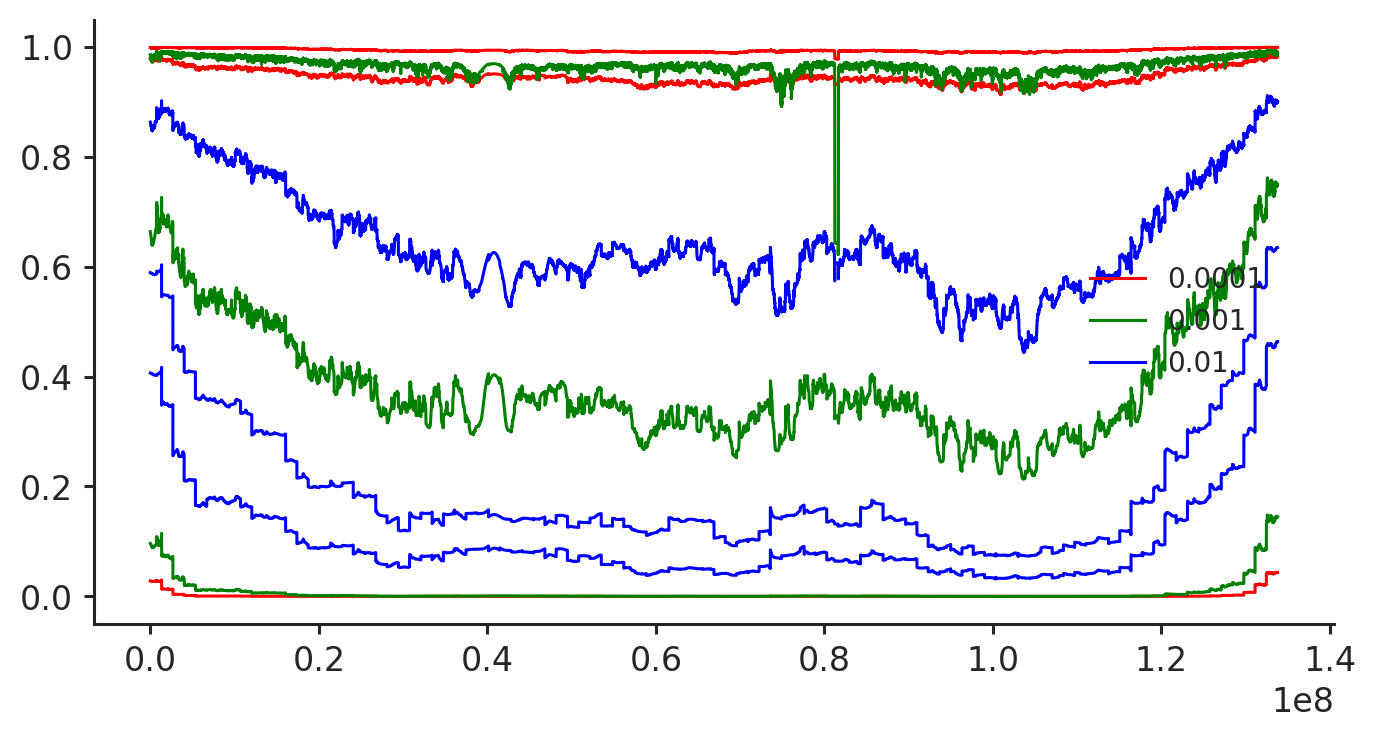

In [233]:
colors = ['r', 'g', 'b']

labs = set()
for i in range(dnnb.B['chr10'].shape[1]):
    for j in range(dnnb.B['chr10'].shape[3]):
        lab = dnnb.t[i] if dnnb.t[i] not in labs else None
        line = plt.plot(dnnb.pos['chr10'], np.exp(dnnb.B['chr10'][0, i, :, j]), c=colors[i], label=lab)
        labs.add(lab)
plt.legend()

In [237]:
from bgspy.learn import LearnedFunction

In [288]:
lf = LearnedFunction.load('../data/segment_logL_logrbp_logrf_wide_0n128_0n64_0n32_0n8_2nx_eluactiv_fit_0rep')

In [289]:
nw, nt = 3, 6

In [290]:
bb = LearnedB(nt, nw, genome=g)
bb.func = lf

In [291]:
bb.func.predict

<bound method LearnedFunction.predict of LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -5] (log10, <ufunc 'log10'>)
  - sh ∈ [-6.3, -1.3] (log10, <ufunc 'log10'>)
  - L ∈ [0.0, 1100] (linear, None)
  - rbp ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -2] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=200,000)
Total size: 1,000,000>

In [301]:
import pandas as pd

In [309]:
Xp

array([[1.00000000e-09, 1.00000000e-04, 2.30000000e+01, 8.77360018e-10,
        1.00003390e-01],
       [1.00000000e-09, 2.00000000e-04, 5.00000000e+01, 1.15564003e-09,
        9.99994827e-02],
       [1.00000000e-09, 1.00000000e-03, 9.41000000e+02, 1.20113997e-09,
        9.99983524e-02],
       ...,
       [1.00000000e-07, 2.00000000e-03, 2.30000000e+02, 3.32218009e-09,
        1.13246572e-01],
       [1.00000000e-07, 1.00000000e-02, 3.65000000e+02, 4.09001011e-09,
        1.13247336e-01],
       [1.00000000e-07, 2.00000000e-02, 7.50000000e+01, 1.00000001e-07,
        1.13248829e-01]])

In [306]:
Xp = np.load('../data/Xp.npy')
d = pd.DataFrame(Xp, columns=('mu', 's', 'L', 'rbp', 'rf'))
Xd = d.sort_values(['mu', 's', 'L', 'rbp', 'rf']).values

In [314]:
np.round(np.prod(bb.theory_B(Xd).reshape((nt, nw, -1)), axis=2), 2)

array([[0.81, 0.82, 0.78],
       [0.8 , 0.84, 0.87],
       [0.19, 0.07, 0.06],
       [0.11, 0.19, 0.25],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ]])

In [324]:
np.round(10**np.sum(np.log10(bb.func.predict(Xd).reshape((nt, nw, -1))), axis=2), 2)

array([[0.97, 0.94, 0.74],
       [0.54, 0.22, 0.21],
       [0.84, 0.54, 0.05],
       [0.01, 0.  , 0.  ],
       [0.32, 0.01, 0.  ],
       [0.  , 0.  , 0.  ]], dtype=float32)

In [437]:
w = ['mu1', 'mu2', 'mu3']
t = ['t1', 't2']
nseg = 5

mesh = np.array(list(itertools.product(w, t)))
mat = np.repeat(mesh, nsegs, axis=0)
aa, bb = mat.T
y = [f"{i}-{j}" for i, j in zip(aa, bb)]
np.array(y).reshape((-1, len(w), len(t)))

array([[['mu1-t1', 'mu1-t1'],
        ['mu1-t1', 'mu1-t1'],
        ['mu1-t1', 'mu1-t1']],

       [['mu1-t1', 'mu1-t1'],
        ['mu1-t1', 'mu1-t1'],
        ['mu1-t1', 'mu1-t1']],

       [['mu1-t1', 'mu1-t2'],
        ['mu1-t2', 'mu1-t2'],
        ['mu1-t2', 'mu1-t2']],

       [['mu1-t2', 'mu1-t2'],
        ['mu1-t2', 'mu1-t2'],
        ['mu1-t2', 'mu1-t2']],

       [['mu1-t2', 'mu1-t2'],
        ['mu2-t1', 'mu2-t1'],
        ['mu2-t1', 'mu2-t1']],

       [['mu2-t1', 'mu2-t1'],
        ['mu2-t1', 'mu2-t1'],
        ['mu2-t1', 'mu2-t1']],

       [['mu2-t1', 'mu2-t1'],
        ['mu2-t1', 'mu2-t2'],
        ['mu2-t2', 'mu2-t2']],

       [['mu2-t2', 'mu2-t2'],
        ['mu2-t2', 'mu2-t2'],
        ['mu2-t2', 'mu2-t2']],

       [['mu2-t2', 'mu2-t2'],
        ['mu2-t2', 'mu2-t2'],
        ['mu3-t1', 'mu3-t1']],

       [['mu3-t1', 'mu3-t1'],
        ['mu3-t1', 'mu3-t1'],
        ['mu3-t1', 'mu3-t1']],

       [['mu3-t1', 'mu3-t1'],
        ['mu3-t1', 'mu3-t1'],
        ['mu3-t1', '

In [433]:
def fake_predict(x):
    y = []
    for i in range(x.shape[0]):
        y.append('-'.join(x[i, ...]))
    return np.array(y)

def fake_sum(x, axis):
    return np.apply_along_axis(lambda x: ','.join(x), axis, x)

In [457]:
mat

array([['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't1'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu1', 't2'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't1'],
       ['mu2', 't2'],
       ['mu2', 't2'],
       ['mu2', 't2'],
       ['mu2', 't2'],
       ['mu2', 't2'],
       ['mu2', 't2'],
       ['m

In [458]:
np.tile([f"s{i}" for i in range(nsegs)], len(w)*len(t))

array(['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
       's11', 's12', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
       's9', 's10', 's11', 's12', 's0', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's0', 's1', 's2',
       's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
       's11', 's12', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
       's9', 's10', 's11', 's12'], dtype='<U3')

In [459]:


M = np.empty((mat.shape[0], 3), dtype=np.dtype('<U3'))
M[:, :2] = mat
M[:, 2] = np.tile([f"s{i}" for i in range(nsegs)], len(w)*len(t))

D = pd.DataFrame(M, columns=('a', 'b', 'c')).sort_values(['a', 'b', 'c']).values
fake_predict(D).reshape((len(w), len(t), -1))

array([[['mu1-t1-s0', 'mu1-t1-s1', 'mu1-t1-s10', 'mu1-t1-s11',
         'mu1-t1-s12', 'mu1-t1-s2', 'mu1-t1-s3', 'mu1-t1-s4',
         'mu1-t1-s5', 'mu1-t1-s6', 'mu1-t1-s7', 'mu1-t1-s8',
         'mu1-t1-s9'],
        ['mu1-t2-s0', 'mu1-t2-s1', 'mu1-t2-s10', 'mu1-t2-s11',
         'mu1-t2-s12', 'mu1-t2-s2', 'mu1-t2-s3', 'mu1-t2-s4',
         'mu1-t2-s5', 'mu1-t2-s6', 'mu1-t2-s7', 'mu1-t2-s8',
         'mu1-t2-s9']],

       [['mu2-t1-s0', 'mu2-t1-s1', 'mu2-t1-s10', 'mu2-t1-s11',
         'mu2-t1-s12', 'mu2-t1-s2', 'mu2-t1-s3', 'mu2-t1-s4',
         'mu2-t1-s5', 'mu2-t1-s6', 'mu2-t1-s7', 'mu2-t1-s8',
         'mu2-t1-s9'],
        ['mu2-t2-s0', 'mu2-t2-s1', 'mu2-t2-s10', 'mu2-t2-s11',
         'mu2-t2-s12', 'mu2-t2-s2', 'mu2-t2-s3', 'mu2-t2-s4',
         'mu2-t2-s5', 'mu2-t2-s6', 'mu2-t2-s7', 'mu2-t2-s8',
         'mu2-t2-s9']],

       [['mu3-t1-s0', 'mu3-t1-s1', 'mu3-t1-s10', 'mu3-t1-s11',
         'mu3-t1-s12', 'mu3-t1-s2', 'mu3-t1-s3', 'mu3-t1-s4',
         'mu3-t1-s5', 'mu3-t1-s6', 

In [460]:
fake_sum( fake_predict(M).reshape((len(w), len(t), -1)), 2)

array([['mu1-t1-s0,mu1-t1-s1,mu1-t1-s2,mu1-t1-s3,mu1-t1-s4,mu1-t1-s5,mu1-t1-s6,mu1-t1-s7,mu1-t1-s8,mu1-t1-s9,mu1-t1-s10,mu1-t1-s11,mu1-t1-s12',
        'mu1-t2-s0,mu1-t2-s1,mu1-t2-s2,mu1-t2-s3,mu1-t2-s4,mu1-t2-s5,mu1-t2-s6,mu1-t2-s7,mu1-t2-s8,mu1-t2-s9,mu1-t2-s10,mu1-t2-s11,mu1-t2-s12'],
       ['mu2-t1-s0,mu2-t1-s1,mu2-t1-s2,mu2-t1-s3,mu2-t1-s4,mu2-t1-s5,mu2-t1-s6,mu2-t1-s7,mu2-t1-s8,mu2-t1-s9,mu2-t1-s10,mu2-t1-s11,mu2-t1-s12',
        'mu2-t2-s0,mu2-t2-s1,mu2-t2-s2,mu2-t2-s3,mu2-t2-s4,mu2-t2-s5,mu2-t2-s6,mu2-t2-s7,mu2-t2-s8,mu2-t2-s9,mu2-t2-s10,mu2-t2-s11,mu2-t2-s12'],
       ['mu3-t1-s0,mu3-t1-s1,mu3-t1-s2,mu3-t1-s3,mu3-t1-s4,mu3-t1-s5,mu3-t1-s6,mu3-t1-s7,mu3-t1-s8,mu3-t1-s9,mu3-t1-s10,mu3-t1-s11,mu3-t1-s12',
        'mu3-t2-s0,mu3-t2-s1,mu3-t2-s2,mu3-t2-s3,mu3-t2-s4,mu3-t2-s5,mu3-t2-s6,mu3-t2-s7,mu3-t2-s8,mu3-t2-s9,mu3-t2-s10,mu3-t2-s11,mu3-t2-s12']],
      dtype='<U132')

In [455]:
fake_sum( fake_predict(D).reshape((len(w), len(t), -1)), 2)

array([['mu1-t1-s0,mu1-t1-s0,mu1-t1-s0,mu1-t1-s0,mu1-t1-s0,mu1-t1-s0,mu1-t1-s1,mu1-t1-s1,mu1-t1-s1,mu1-t1-s1,mu1-t1-s1,mu1-t1-s1,mu1-t1-s2',
        'mu1-t2-s2,mu1-t2-s2,mu1-t2-s2,mu1-t2-s2,mu1-t2-s2,mu1-t2-s3,mu1-t2-s3,mu1-t2-s3,mu1-t2-s3,mu1-t2-s3,mu1-t2-s3,mu1-t2-s4,mu1-t2-s4'],
       ['mu2-t1-s4,mu2-t1-s4,mu2-t1-s4,mu2-t1-s4,mu2-t1-s5,mu2-t1-s5,mu2-t1-s5,mu2-t1-s5,mu2-t1-s5,mu2-t1-s5,mu2-t1-s6,mu2-t1-s6,mu2-t1-s6',
        'mu2-t2-s6,mu2-t2-s6,mu2-t2-s6,mu2-t2-s7,mu2-t2-s7,mu2-t2-s7,mu2-t2-s7,mu2-t2-s7,mu2-t2-s7,mu2-t2-s8,mu2-t2-s8,mu2-t2-s8,mu2-t2-s8'],
       ['mu3-t1-s10,mu3-t1-s10,mu3-t1-s10,mu3-t1-s10,mu3-t1-s10,mu3-t1-s8,mu3-t1-s8,mu3-t1-s9,mu3-t1-s9,mu3-t1-s9,mu3-t1-s9,mu3-t1-s9,mu3-',
        'mu3-t2-s10,mu3-t2-s11,mu3-t2-s11,mu3-t2-s11,mu3-t2-s11,mu3-t2-s11,mu3-t2-s11,mu3-t2-s12,mu3-t2-s12,mu3-t2-s12,mu3-t2-s12,mu3-t2-s']],
      dtype='<U129')

In [323]:
np.round(10**np.sum(np.log10(bb.
                             (Xd).reshape((nt, nw, -1))), axis=2), 2)

array([[0.97, 0.94, 0.74],
       [0.54, 0.22, 0.21],
       [0.84, 0.54, 0.05],
       [0.01, 0.  , 0.  ],
       [0.32, 0.01, 0.  ],
       [0.  , 0.  , 0.  ]], dtype=float32)

In [320]:
np.array(2 * [f"{i}-{j}" for i, j in itertools.product(range(5), range(4))]).reshape((4, 5, -1))

array([[['0-0', '0-1'],
        ['0-2', '0-3'],
        ['1-0', '1-1'],
        ['1-2', '1-3'],
        ['2-0', '2-1']],

       [['2-2', '2-3'],
        ['3-0', '3-1'],
        ['3-2', '3-3'],
        ['4-0', '4-1'],
        ['4-2', '4-3']],

       [['0-0', '0-1'],
        ['0-2', '0-3'],
        ['1-0', '1-1'],
        ['1-2', '1-3'],
        ['2-0', '2-1']],

       [['2-2', '2-3'],
        ['3-0', '3-1'],
        ['3-2', '3-3'],
        ['4-0', '4-1'],
        ['4-2', '4-3']]], dtype='<U3')

In [307]:
np.round(10**np.sum(np.log10(bb.func.predict(Xd).reshape((-1, nw, nt))), axis=0), 2)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

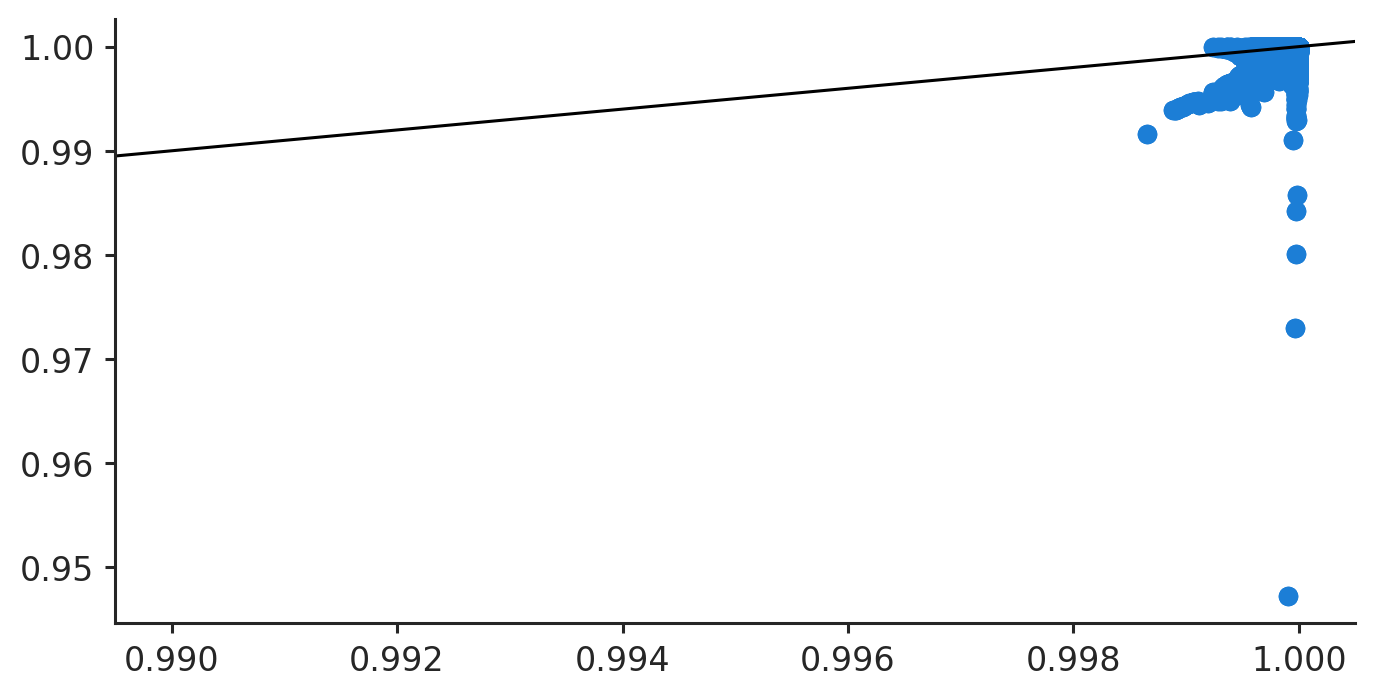

In [278]:
fig, ax = plt.subplots()
ax.scatter(bb.func.predict(Xp), bb.theory_B(Xp))
o = 0.99
ax.axline((o, o), slope=1, c='k')

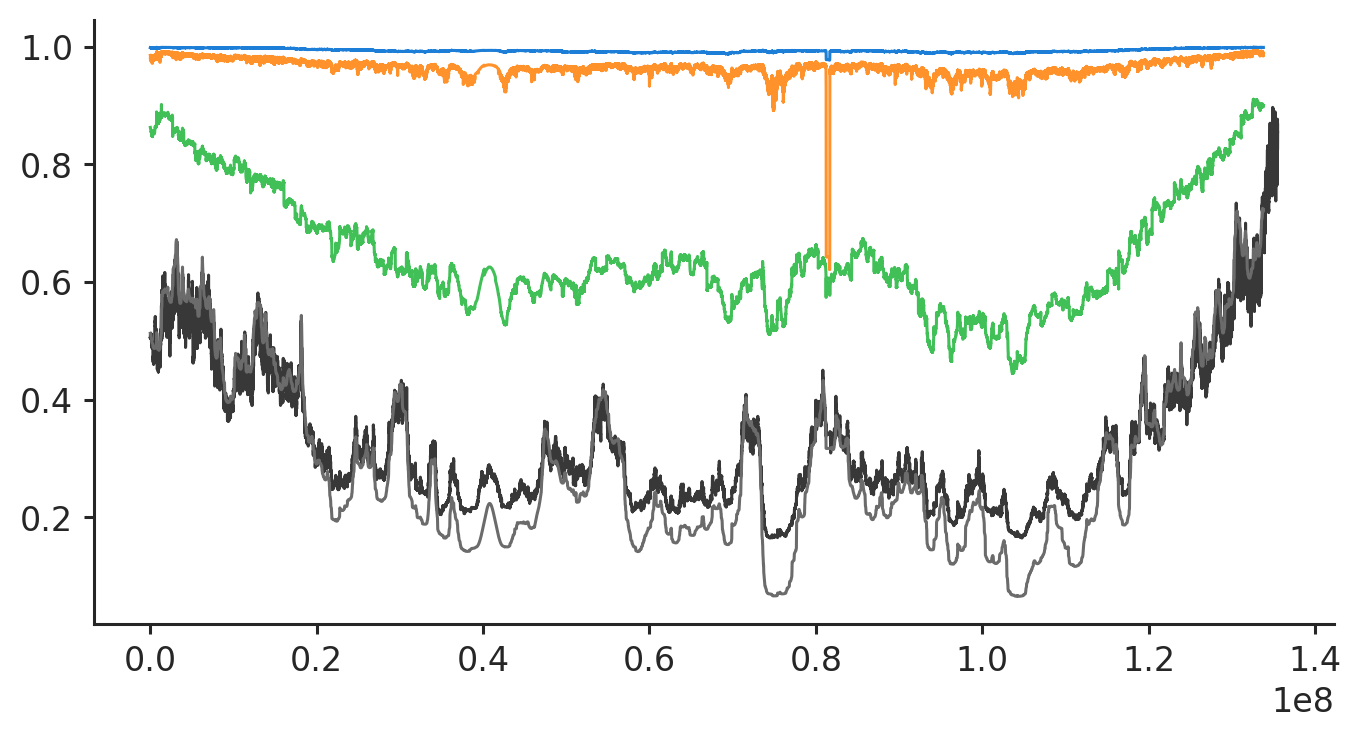

In [283]:
for i, t in enumerate(dnnb.t):
    plt.plot(dnnb.pos['chr10'], np.exp(dnnb.B['chr10'][0, i, :, 2]), label='dnn b') 

t, w = 0.01, 1e-8
pos, sim_bs = sims[(('sh', t), ('mu', w))]
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims', c='0.22')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, arg_nearest(w, b.w), arg_nearest(t, b.t)]), c='0.42')


In [183]:
import itertools
import pandas as pd

In [184]:
w, t = [1e-8, 1e-9], [1e-4, 1e-3, 1e-2]
mesh = np.array(list(itertools.product(w, t)))

segments = np.arange(13)

In [185]:
mesh, segments

(array([[1.e-08, 1.e-04],
        [1.e-08, 1.e-03],
        [1.e-08, 1.e-02],
        [1.e-09, 1.e-04],
        [1.e-09, 1.e-03],
        [1.e-09, 1.e-02]]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [198]:
nmesh, nsegs = mesh.shape[0], len(segments)
X = np.empty((nsegs*nmesh, 3))

X[:, :2] = np.tile(mesh, (len(segments), 1))
X[:, 2] = np.tile(segments, nmesh)

In [195]:
d = pd.DataFrame(X, columns=('mu', 's', 'L'))
d.sort_values(['mu', 's', 'L'])

,mu,s,L
39,1.000000e-09,0.0001,0.0
27,1.000000e-09,0.0001,1.0
15,1.000000e-09,0.0001,2.0
3,1.000000e-09,0.0001,3.0
69,1.000000e-09,0.0001,4.0
...,...,...,...
8,1.000000e-08,0.0100,8.0
74,1.000000e-08,0.0100,9.0
62,1.000000e-08,0.0100,10.0
50,1.000000e-08,0.0100,11.0


In [196]:
X

array([[1.0e-08, 1.0e-04, 0.0e+00],
       [1.0e-08, 1.0e-03, 1.0e+00],
       [1.0e-08, 1.0e-02, 2.0e+00],
       [1.0e-09, 1.0e-04, 3.0e+00],
       [1.0e-09, 1.0e-03, 4.0e+00],
       [1.0e-09, 1.0e-02, 5.0e+00],
       [1.0e-08, 1.0e-04, 6.0e+00],
       [1.0e-08, 1.0e-03, 7.0e+00],
       [1.0e-08, 1.0e-02, 8.0e+00],
       [1.0e-09, 1.0e-04, 9.0e+00],
       [1.0e-09, 1.0e-03, 1.0e+01],
       [1.0e-09, 1.0e-02, 1.1e+01],
       [1.0e-08, 1.0e-04, 1.2e+01],
       [1.0e-08, 1.0e-03, 0.0e+00],
       [1.0e-08, 1.0e-02, 1.0e+00],
       [1.0e-09, 1.0e-04, 2.0e+00],
       [1.0e-09, 1.0e-03, 3.0e+00],
       [1.0e-09, 1.0e-02, 4.0e+00],
       [1.0e-08, 1.0e-04, 5.0e+00],
       [1.0e-08, 1.0e-03, 6.0e+00],
       [1.0e-08, 1.0e-02, 7.0e+00],
       [1.0e-09, 1.0e-04, 8.0e+00],
       [1.0e-09, 1.0e-03, 9.0e+00],
       [1.0e-09, 1.0e-02, 1.0e+01],
       [1.0e-08, 1.0e-04, 1.1e+01],
       [1.0e-08, 1.0e-03, 1.2e+01],
       [1.0e-08, 1.0e-02, 0.0e+00],
       [1.0e-09, 1.0e-04, 1.

In [140]:
b = np.random.uniform(0, 1, 100)
10**(np.sum(np.log10(b))), np.prod(b)

(2.415958072958279e-44, 2.415958072958297e-44)

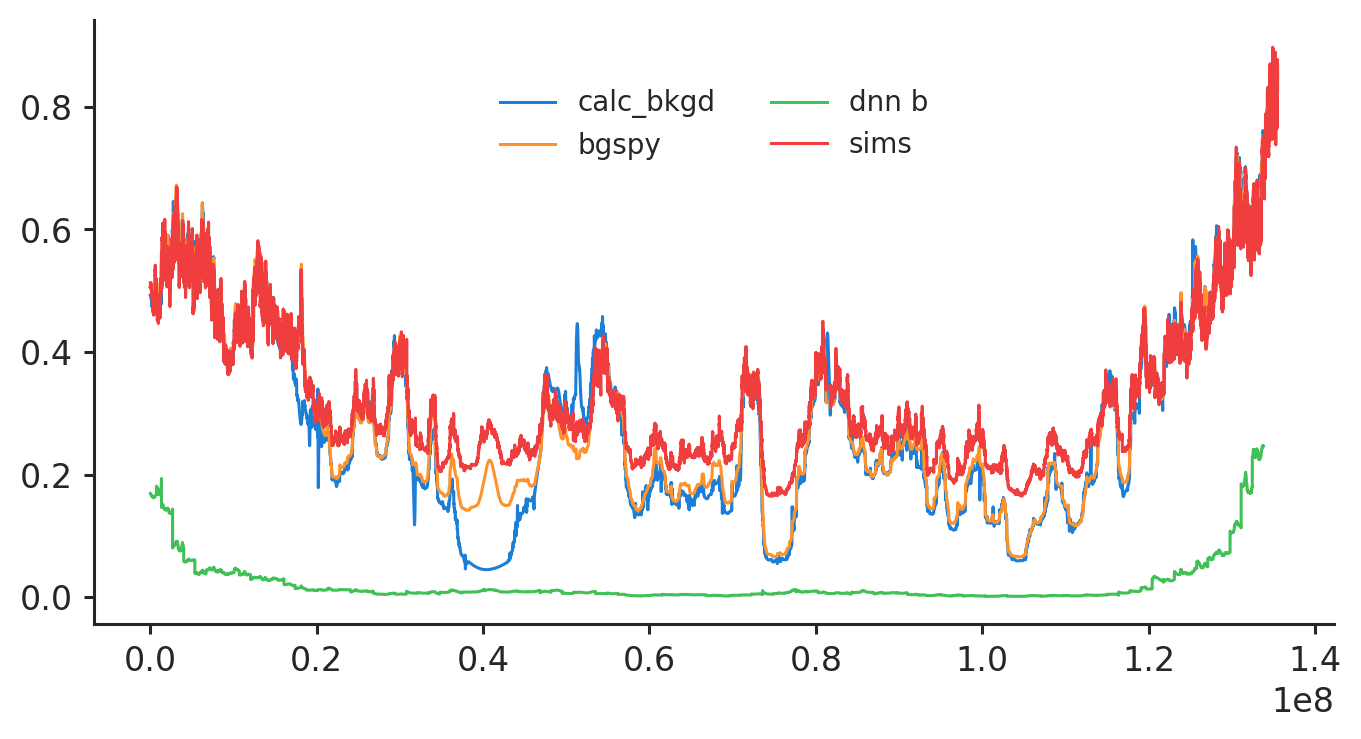

In [104]:
plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 3], label='calc_bkgd')
plt.plot(b.pos['chr10'], np.exp(b.B['chr10'][:, 1, 1]), label='bgspy')
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 3, :], label='dnn b')
plt.plot(pos[1:], sim_bs.mean(axis=1), label='sims')
plt.legend(ncol=2)

(0.0, 1.0)

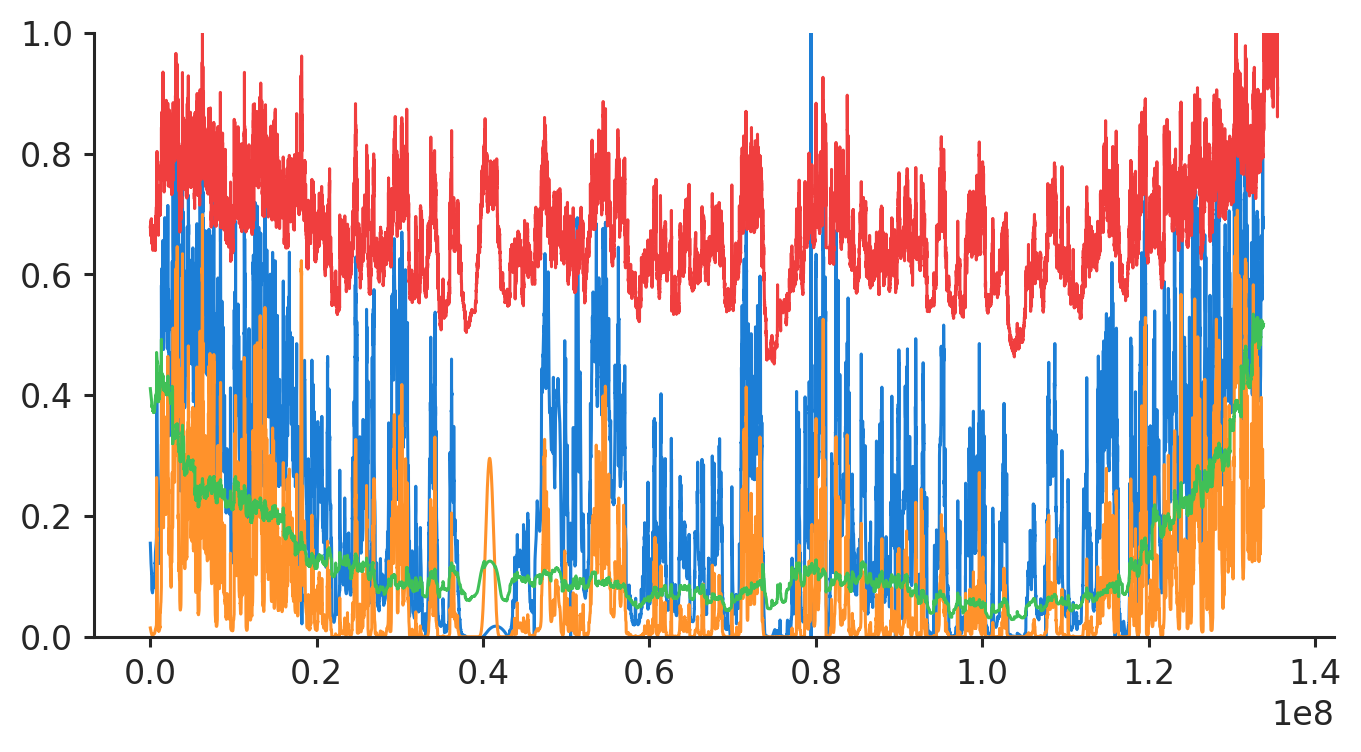

In [72]:
pos, sim_bs = sims[(('sh', 0.001), ('mu', 1e-08))]

plt.plot(mcvb.pos['chr10'], mcvb.B['chr10'][:, 0, 2])
plt.plot(b.pos['chr10'], 10**b.B['chr10'][:, 2, 2])
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])
plt.plot(pos[1:], sim_bs.mean(axis=1))
plt.ylim(0, 1)

In [66]:
dnnb.w, dnnb.t

(array([1.e-07, 1.e-08, 1.e-09]),
 array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]))

### Simulation Results

In [9]:
np.diff(m.segments.ranges, axis=1)

array([[1000],
       [1000],
       [1000],
       ...,
       [ 143],
       [1000],
       [ 241]], dtype=uint32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:39<00:00,  3.13it/s]


In [74]:
sims.keys()

dict_keys([(('sh', 0.0001), ('mu', 1e-08)), (('sh', 0.001), ('mu', 1e-08)), (('sh', 1e-05), ('mu', 1e-08)), (('sh', 0.1), ('mu', 1e-08)), (('sh', 0.01), ('mu', 1e-08)), (('s', 0.02), ('mu', 1e-08))])

In [9]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'
with open(cached_bgsmap_file, 'wb') as f:
    pickle.dump(sims, f)  

In [10]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'

force = False

if force or not os.path.exists(cached_bgsmap_file):
    sims = load_b_chrom_sims(DATADIR)
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

In [14]:
i = np.zeros(g.seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // 100_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

### Load DNNB

In [35]:
dnnb = LearnedB.load_predictions(g, '../data/dnnb')

In [36]:
dnnb.w, dnnb.t, dnnb.B['chr10'].shape

(array([1.e-07, 1.e-08, 1.e-09]),
 array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
 (3, 5, 133799))

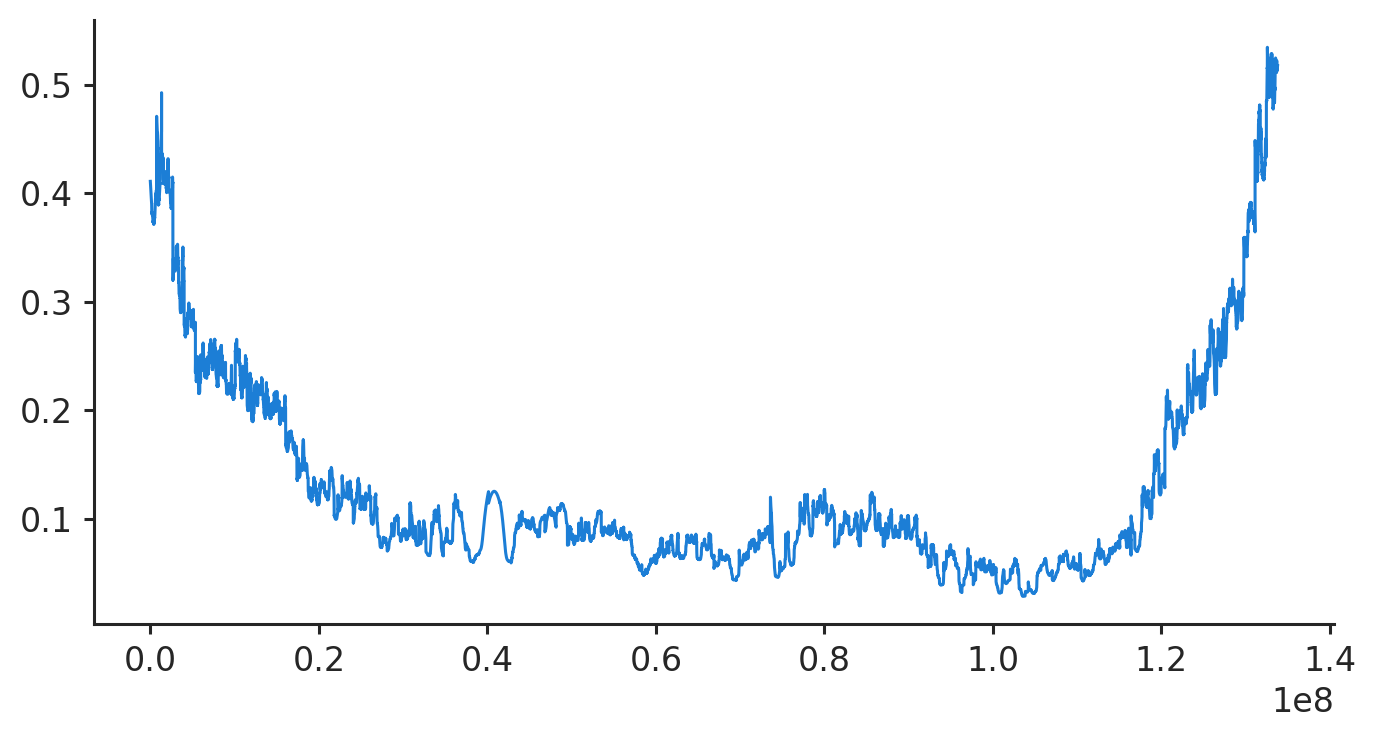

In [48]:
plt.plot(dnnb.pos['chr10'], 10**dnnb.B['chr10'][1, 1, :])

1e-08 0.01


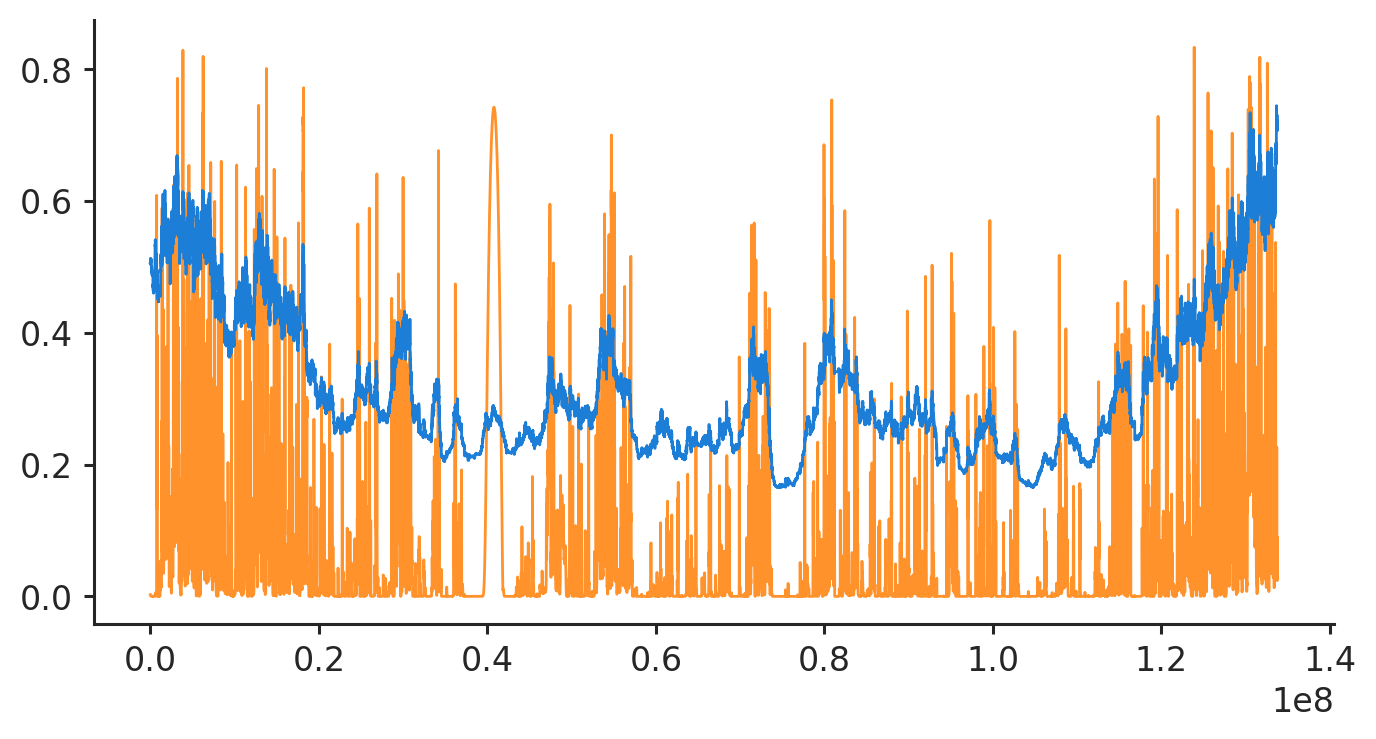

In [89]:
fig, ax = plt.subplots()

line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], 10**(bgspy_b), label="bgspy", linewidth=lw, zorder=5)

1e-08 0.01


NameError: name 'bkgd' is not defined

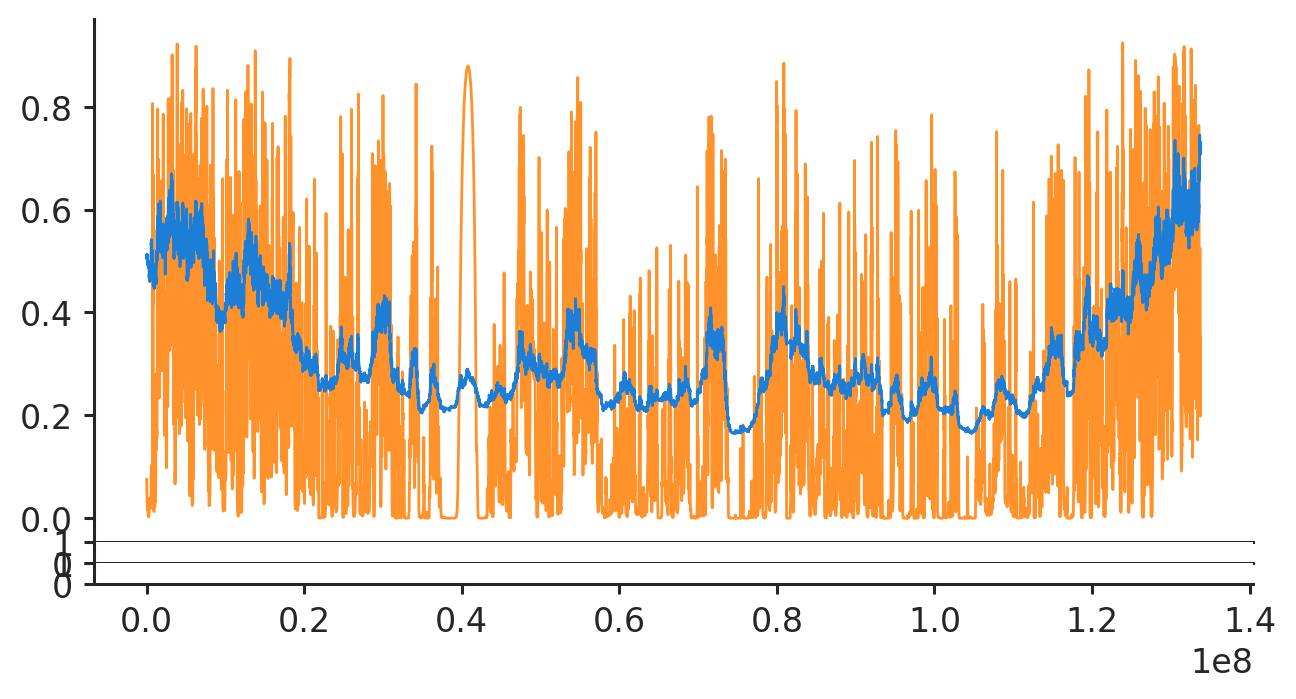

In [85]:
s, mu = 0.01, 1e-8
pos_all, b_all = sims[(('sh', s), ('mu', mu))]

bvar = b_all.var(axis=1)
bmean = b_all.mean(axis=1)

max_pos = np.max(m.BScores.pos['chr10'])

pos, bmean, bvar = pos_all[pos_all < max_pos], bmean[midpoint(pos_all) < max_pos], bvar[midpoint(pos_all) < max_pos], 

## main plot
gridkw =  {"height_ratios": [5, 0.2, 0.2], "hspace": 0}
fig, (ax, gene_ax, rec_ax) = plt.subplots(ncols=1, nrows=3, gridspec_kw=gridkw, sharex=True)
fig.set_size_inches(*fig_sizes['two', 'two'])
lw = 1
line = ax.plot(pos, bmean, label="simulations", linewidth=lw, zorder=20)
print(m.w[arg_nearest(mu, m.w)], m.t[arg_nearest(s, m.t)])
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy", linewidth=lw, zorder=5)
line = ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd", linewidth=lw)

# B intervals
lower, upper = bmean + np.sqrt(bvar), bmean - np.sqrt(bvar)
lower2, upper2 = bmean + 2*np.sqrt(bvar), bmean - 2*np.sqrt(bvar)
rec_sigma = 1.75e2
smooth_lower = gaussian_filter1d(lower, rec_sigma)
smooth_upper = gaussian_filter1d(upper, rec_sigma)
ribbon = ax.fill_between(pos, smooth_lower, smooth_upper, interpolate=True, alpha=0.2)

leg = ax.legend(loc=(0.7, 0.7), fontsize=9)
for lh in leg.legendHandles:
    lh.set_linewidth(2)

ax.set_xticklabels([])
ax.tick_params(bottom=False)  
ax.set_ylabel('B')
#ax.set_ylim(0, 0.8)
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(np.round(100*x))}%")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', 6.6))

n = 10
bar_height = 1
axis_pad = bar_height
ends, rates = m.recmap.rates['chr10']
ends, rates = ends[ends < max_pos], rates[ends < max_pos]
rates[0] = 0
rate_min = 0 # np.quantile(rates, 0.1)
rate_max = 3e-8 # np.quantile(rates, 0.9)
norm = plt.Normalize(rate_min, rate_max)
smooth_rates = gaussian_filter1d(rates, 300)
rec_cbar = rec_ax.pcolormesh(ends, np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm)
rec_ax.set_yticks([])
rec_ax.set_xticks(np.arange(0, 1.4e8+1, 20_000_000))
rec_ax.set_xticklabels(np.arange(0, 1.4e8+1, 20_000_000)/1e8)
rec_ax.set_xlabel('position')
rec_ax.tick_params(left=False) 
rec_ax.spines['left'].set_visible(False)

# gene density
ends, density = coverage.bin_edges, 100*coverage.statistic/(coverage.bin_edges[1:] - coverage.bin_edges[:-1])
norm = plt.Normalize(density.min(), density.max())
smooth_rates = gaussian_filter1d(density, 1)
gene_cbar = gene_ax.pcolormesh(ends[:-1], np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm, cmap='plasma')
gene_ax.axis('off')
offset = 0.04

# color bar axes
width = 0.015
start = 0.925
cax2 = fig.add_axes([offset+start+width, 0.35, width, 0.4])
cax1 = fig.add_axes([offset+start, 0.35, width, 0.4])
cbar1 = fig.colorbar(rec_cbar, cax=cax1)
cbar2 = fig.colorbar(gene_cbar, cax=cax2)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 1e-8, 2e-8, 3e-8]))
cax1.set_yticklabels(np.array([0, 1, 2, 3]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=10)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('conserved density', fontsize=10, rotation=-90)
cax1.tick_params(labelsize=8)
cax2.tick_params(labelsize=8)
cbar1.outline.set_linewidth(1)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(1) 
cax1.yaxis.set_tick_params(width=1)
cax2.yaxis.set_tick_params(width=1)

def centro_notch(ax, coords, seqlen, c=2.5, lw=1, lc='0.22', flip=False):
    ymin, ymax = ax.get_ylim()
    m = 1/c if not flip else 1-1/c
    ymid = (ymin + ymax)*m
    if flip:
        ymin, ymax = ymax, ymin
    start, cent, end = coords
    verts = [(start, ymax*1.1), (cent, ymid), (end, ymax*1.1)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    centro_verts = mpath.Path(verts, codes)
    centro_marker = patches.PathPatch(centro_verts, facecolor='white', lw=0)
    ax.add_patch(centro_marker)
    ax.plot([0, 0, start, cent, end, seqlen, seqlen], [ymin, ymax, ymax, ymid, ymax, ymax, ymin], c=lc, linewidth=lw)
    
#centro_notch(gene_ax, centro['chr10'], seqlen=seqlens['chr10'])
#centro_notch(rec_ax, centro['chr10'],  seqlen=seqlens['chr10'], flip=True)
rec_ax.spines['bottom'].set_position(('outward', 4))


In [63]:
bins = bin_chrom(g.seqlens['chr10'], 1e6)

sim_x, sim_y = pos, bmean
mcv_x, mcv_y = bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1]

In [64]:
np.nanmean((stats.binned_statistic(mcv_x, mcv_y, bins=bins).statistic - stats.binned_statistic(sim_x, sim_y, bins=bins).statistic)**2)

0.1457656152682091

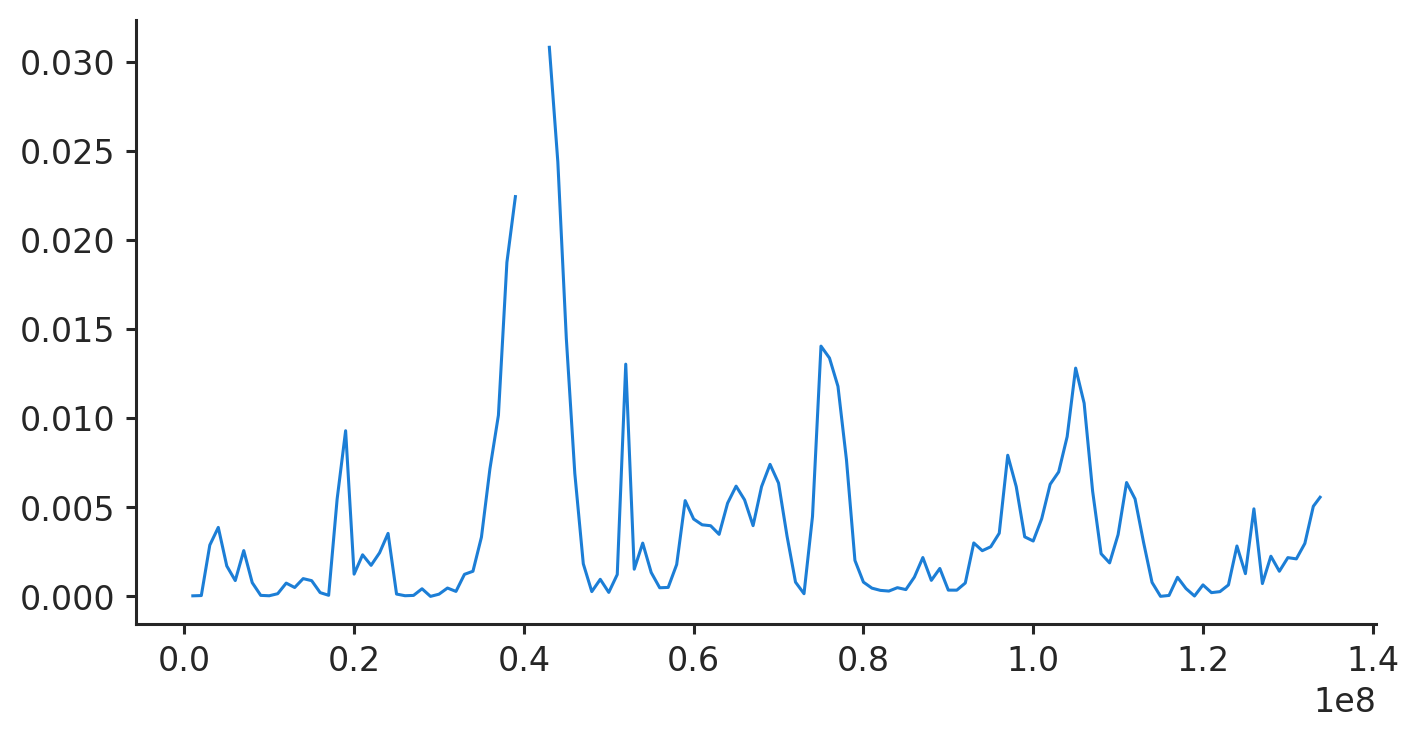

In [54]:
plt.plot(stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).bin_edges[1:], (stats.binned_statistic(sim_x, sim_y, bins=bins, statistic=np.nanmean).statistic - stats.binned_statistic(mcv_x, mcv_y, bins=bins, statistic=np.nanmean).statistic)**2)

In [75]:
m = np.arange(100).reshape((25, 4))
#m + np.arange(25)[:, None]
m + np.arange(4)

array([[  0,   2,   4,   6],
       [  4,   6,   8,  10],
       [  8,  10,  12,  14],
       [ 12,  14,  16,  18],
       [ 16,  18,  20,  22],
       [ 20,  22,  24,  26],
       [ 24,  26,  28,  30],
       [ 28,  30,  32,  34],
       [ 32,  34,  36,  38],
       [ 36,  38,  40,  42],
       [ 40,  42,  44,  46],
       [ 44,  46,  48,  50],
       [ 48,  50,  52,  54],
       [ 52,  54,  56,  58],
       [ 56,  58,  60,  62],
       [ 60,  62,  64,  66],
       [ 64,  66,  68,  70],
       [ 68,  70,  72,  74],
       [ 72,  74,  76,  78],
       [ 76,  78,  80,  82],
       [ 80,  82,  84,  86],
       [ 84,  86,  88,  90],
       [ 88,  90,  92,  94],
       [ 92,  94,  96,  98],
       [ 96,  98, 100, 102]])

In [ ]:
ribbon.get_facecolor()

Bias by recombination?

In [ ]:
np.repeat(rates[:, None], 100, axis=1).shape

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
binterpols = m.BScores_interpolater(0)

In [ ]:
fig = plt.figure()

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(*fig_sizes['two', 'one'])
x = bmean
y = np.exp(binterpols['chr10'][(1e-8, 1e-2)](midpoint(pos)))
bkgd_y = bkgd[s/2]['chr10'][1]
bkgd_func = interpolate.interp1d(bkgd[s/2]['chr10'][0], bkgd_y, fill_value=(bkgd_y[0], bkgd_y[-1]), bounds_error=False, kind='quadratic')
z = bkgd_func(midpoint(pos))

def corr(x, y, digits=2):
    return np.round(np.corrcoef(x, y)[0, 1], digits)

mae = lambda x, y: np.round(MAE(x, y), 2)

sc0 = ax[0].scatter(x, z, s=5, alpha=0.4, label='calc_bkgd', linewidth=0)
sc1 = ax[0].scatter(x, y, s=5, alpha=0.4, label='bgspy', linewidth=0)
ax[0].text(0.45, 0.1, f"$R^2 = {corr(x, z)}, MAE = {mae(x, z)}$", c=sc0.get_facecolors()[0], alpha=1, size=8)
ax[0].text(0.45, 0.05, f"$R^2 = {corr(x, y)}, MAE = {mae(x, y)}$", c=sc1.get_facecolors()[0], alpha=1, size=8)
ax[0].axline((0.1, 0.1), slope=1, c='#e03131', linestyle='dashed')
ax[0].set_xlabel("$\mathrm{E}(B)$ from simulations")
ax[0].set_ylabel("B Scores")
ax[0].set_aspect('equal', 'box')
ax[0].set_yticks(np.linspace(0, 0.8, 5))
ax[0].set_xlim((0, 0.8))
ax[0].set_ylim((0, 0.8))
leg = ax[0].legend(loc=(-0.05, 0.7))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([50] * len(lh.get_sizes()))

#ax[1].scatter(z, y, s=4, c=(x-z)/x, cmap='brg')
ax[1].scatter(z, y, s=5, c='0.22', alpha=0.1, linewidth=0)
ax[1].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(z, y)[0, 1], 2)}$")
ax[1].axline((0, 0), slope=1, c='#e03131', linestyle='dashed')
ax[1].set_xlabel("calc_bkgd")
ax[1].set_ylabel("bgspy")
ax[1].set_yticks(np.linspace(0, 0.8, 5))
ax[1].set_xlim((0, 0.8))
ax[1].set_ylim((0, 0.8))
ax[1].set_aspect('equal', 'box')
plt.tight_layout()

In [ ]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic/100_000)

In [ ]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')